In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import random
import warnings
import string
import imutils
import datetime
warnings.filterwarnings("ignore")
%matplotlib inline

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
test_name = pd.read_csv('C:/Users/mdamr/Downloads/archive/written_name_test_v2.csv')

In [4]:
test_name = test_name[test_name['IDENTITY'] != 'UNREADABLE']

In [5]:
test_name['IDENTITY'] = test_name['IDENTITY'].str.upper()

In [6]:
test_name.reset_index(inplace = True, drop = True)

In [7]:
def increaseImageQuality(img):
    # Check image type and convert if necessary
    if img.dtype != np.uint8:
        img = np.uint8(img / np.max(img) * 255)
    # Increase the contrast of the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Sharpen the image
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    img = cv2.filter2D(img, -1, kernel)
    
    return img

In [17]:
def preprocessImage(img):
    (h, w) = img.shape

    # Calculate the new size while preserving the aspect ratio
    max_width = 256
    max_height = 64
    aspect_ratio = float(img.shape[1]) / img.shape[0]
    new_width = int(max_height * aspect_ratio)
    new_height = max_height

    if new_width > max_width:
        new_width = max_width
        new_height = int(new_width / aspect_ratio)

    # Ensure that the new height is at least 31 pixels
    if new_height < 31:
        new_height = 31
        new_width = int(new_height * aspect_ratio)

    # Resize the image
    if h < max_height and w < max_width:
        resized_image = img
    else:
        resized_image = imutils.resize(img, width=width=new_width, height = new_height)

    # Calculate the padding values
    top = max(0, (h - new_height) // 2)
    bottom = max(0, h - new_height - top)
    left = max(0, (w - new_width) // 2)
    right = max(0, w - new_width - left)

    # Add padding if necessary
    resized_image_with_padding = resized_image
    #resized_image_with_padding = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # Create a blank white image with the final size
    final_img = np.ones([64, 256])*255 

    # Resize the padded image to fit the final size
    resized_padded_image = cv2.resize(resized_image_with_padding, (256, 64), interpolation=cv2.INTER_AREA)

    # Copy the resized padded image to the final image
    final_img[:resized_padded_image.shape[0], :resized_padded_image.shape[1]] = resized_padded_image
    final_img = increaseImageQuality(final_img)
    # Rotate the final image 90 degrees clockwise
    final_img = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite('test.png',final_img)
    return final_img

SyntaxError: invalid syntax (1357228967.py, line 24)

In [18]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [10]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [11]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [12]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [13]:
model = tf.keras.models.load_model('new_model.h5')

1/1 [==============================] - 0s 22ms/step


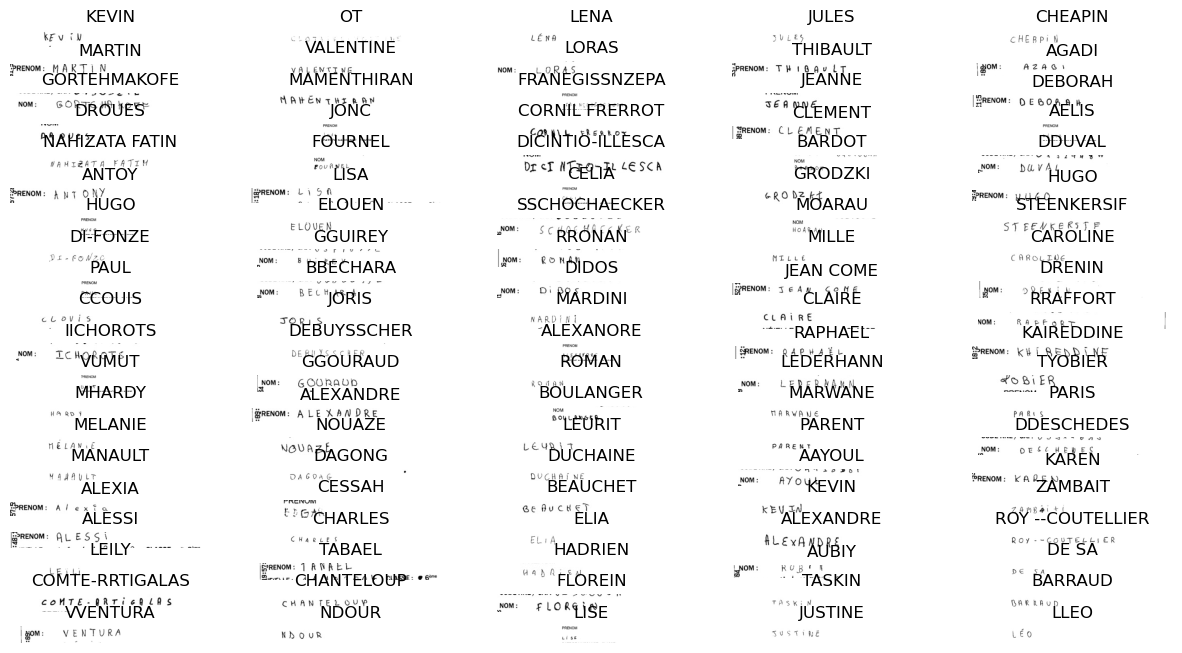

In [19]:
plt.figure(figsize=(15, 10))
for i in range(100):
    ax = plt.subplot(25, 5, i+1)
    img_dir = 'C:/Users/mdamr/Downloads/archive/test_v2/test/'+test_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocessImage(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=0.8)

1/1 [==============================] - 0s 51ms/step


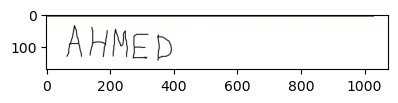

In [37]:
from PIL import Image, ImageDraw, ImageOps
plt.figure(figsize=(15, 10))
images = ['C:/Users/mdamr/Downloads/archive/test_v2/test/test1.jpg']
for i in range(1):
    ax = plt.subplot(2, 3, i+1)
    image = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    image = preprocessImage(image)
   
    image = image/255.
    #plt.imshow(image, cmap='gray')
#     plt.plot(image)
    image = imutils.resize(image, width = 256, height = 64)
    plt.plot(image)
    image = image.reshape(1, 256, 64, -1)
    pred = model.predict(image)
    
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
#     plt.title(num_to_label(decoded[0]), fontsize=12)
#     plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)